# Part A. Document Clustering

# Question 1 [EM for Document Clustering, 40 Marks]

1. Derive Expectation and Maximization steps of the hard-EM algorithm for Document Clustering, show your work in your submitted PDF report. In particular, include all model parameters that should be learnt and the exact expression (using the same math convention that we saw in the Module 4) that should be used to update these parameters during the learning process (ie., E step, M step and assignments).

In [1]:
# loading required libraries
library('tm')
library('SnowballC')

Warning message:
"package 'tm' was built under R version 4.0.5"
Loading required package: NLP

Warning message:
"package 'NLP' was built under R version 4.0.3"
Warning message:
"package 'SnowballC' was built under R version 4.0.3"


2. Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

In [2]:
# initialization function
initialize_func <- function(vocab_size, K=4, seed=0) {
    # Initializing clusters with the same probability ratio
    rho = matrix(1/K, nrow = K, ncol=1) 
    # Generating  and initializing the parameter matrix mu
    mu = matrix(runif(K * vocab_size),nrow=K, ncol=vocab_size)
    # normalize to 1
    mu = prop.table(mu, margin=1)               
    return (list("rho" = rho, "mu"= mu))
}

In [3]:
# helper function
logSum <- function(v) {
    m = max(v)
    return ( m + log(sum(exp(v-m))))
}


# the training objective function
train.objective <- function(model, counts) { 
  N = dim(counts)[2] # N documents
  K = dim(model$mu)[1] # K clusters
   
  nloglike = 0
  for (n in 1:N){
    lprob = matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike = nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

In [4]:
E_step_func <- function(gamma, model, counts){
    N = dim(counts)[2] # N documents
    K = dim(model$mu)[1] # K clusters
    # E step:    
    for (n in 1:N){
        for (k in 1:K){
          ## calculate the posterior based on the estimated mu and rho in the "log space"
          gamma[n,k] = log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
        }
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
    }
    # converting back from the log space 
    gamma = exp(gamma)
    return (gamma)
}

In [5]:
M_step_func <- function(gamma, model, counts) {
    N = dim(counts)[2]   # N documents
    W = dim(counts)[1]   # W words
    K = dim(model$mu)[1] # K clusters
    
    # normalize gamma
    gamma = prop.table(gamma + 0.000001, 1)
    for (k in 1:K){
        # update rho: cluster probabilities
        model$rho[k] <- sum(gamma[,k])/N
        # update mu parameter for each word in cluster
        model$mu[k,] = rowSums(gamma[, k] * counts) / sum(rowSums(gamma[, k] * counts))
    }
    # Return the result
    return (model)
}

In [6]:
EM_func <- function(counts, K=4, max.epoch=100, seed=123456, hard=FALSE) {
    N = dim(counts)[2] # number of documents
    W = dim(counts)[1] # number of unique words (in all documents)
    
    # Initialization
    model = initialize_func(W, K=K, seed=seed)
    gamma = matrix(0, nrow = N, ncol = K)
    
    if (hard == TRUE) {
        # Do hard label assignment
        max.prob = gamma == apply(gamma, 1, max)
        gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
        gamma[!max.prob] <- 0 
    }
    
    print(train_obj(model,counts))
    
    # Start train the model
    for(epoch in 1:max.epoch){
        # E Step
        gamma = E_step_func(gamma, model, counts)
        # M Step
        model = M_step_func(gamma, model, counts)
        print(train_obj(model,counts)) 
    }
    # Return Model
    return(list("model"=model,"gamma"=gamma))
}

In [7]:
cluster_viz_func <- function(doc.word.mat, color.vector, title=' '){
    p.comp = prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
    plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

In [8]:
# helper function
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [9]:
# the training objective function
train_obj <- function(model, counts) { 
  N = dim(counts)[2] # number of documents
  K = dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike = nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

3. Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [10]:
readText <-  function(filename){
    text = readLines(filename)
    docs = strsplit(text, '\t')
    rm(text)
    
    labels =  unlist(lapply(docs, function(x) x[1]))
    docs = data.frame("doc_id"=1:length(docs), "text"=unlist(lapply(docs, function(x) x[2])))
    docs = DataframeSource(docs)
    docs = Corpus(docs)

    # Preprocessing of the data:
    docs = tm_map(docs, removeWords, stopwords("english")) # remove stop words (the most common words in a language that can be found in any document)
    docs = tm_map(docs, removePunctuation) # remove punctuations
    docs = tm_map(docs, stemDocument) # perform stemming process by reducing inflected and derived words to their root form
    docs = tm_map(docs, removeNumbers) # remove all numbers from the text
    docs = tm_map(docs, stripWhitespace) # removing redundant spaces within the text 

    # Create a matrix which its rows are the documents and colomns are the words. 
    ## Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
    tdm = TermDocumentMatrix(docs, control=list("weighting"=function(x) weightTfIdf(x, normalize = FALSE)))

    ## reduce the sparcity of out dtm
    tdm = removeSparseTerms(tdm, 0.90)
    return (list("tdm"=tdm, "labels"=labels))
 
}

In [11]:
# loading data
data = readText("Dataset and Sample code/Task2A.txt")
counts = as.matrix(data$tdm)
labels = data$labels

Warning message in TermDocumentMatrix.SimpleCorpus(docs, control = list(weighting = function(x) weightTfIdf(x, :
"custom functions are ignored"


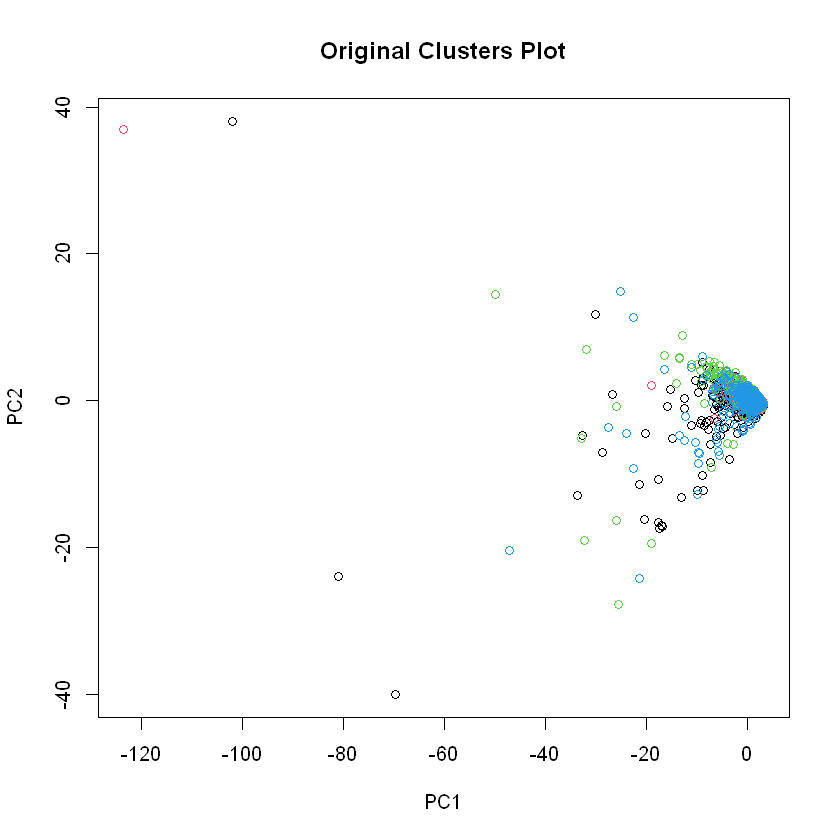

In [12]:
# plotting of the original clusters
labels_T = as.numeric(factor(labels))
cluster_viz_func(t(counts), labels_T, 'Original Clusters Plot')

In [13]:
# Hard clustering
hard_cluster_results = EM_func(counts, hard=TRUE)

[1] 1069088
[1] 1030329
[1] 1031704
[1] 1031914
[1] 1032011
[1] 1031794
[1] 1031768
[1] 1031820
[1] 1031911
[1] 1031793
[1] 1031398
[1] 1031829
[1] 1031748
[1] 1031931
[1] 1031723
[1] 1031997
[1] 1031695
[1] 1031857
[1] 1031790
[1] 1031708
[1] 1031142
[1] 1031506
[1] 1031780
[1] 1031790
[1] 1031352
[1] 1031604
[1] 1031478
[1] 1031549
[1] 1031695
[1] 1031766
[1] 1031400
[1] 1031747
[1] 1031773
[1] 1032205
[1] 1031815
[1] 1031405
[1] 1031426
[1] 1031487
[1] 1031780
[1] 1031808
[1] 1031796
[1] 1031787
[1] 1031325
[1] 1031562
[1] 1031790
[1] 1031665
[1] 1031730
[1] 1031831
[1] 1032030
[1] 1031505
[1] 1031054
[1] 1031551
[1] 1031900
[1] 1031801
[1] 1032100
[1] 1031861
[1] 1031782
[1] 1031323
[1] 1031424
[1] 1031409
[1] 1032232
[1] 1032011
[1] 1032000
[1] 1031934
[1] 1031928
[1] 1031566
[1] 1031954
[1] 1031963
[1] 1032054
[1] 1031797
[1] 1031998
[1] 1031709
[1] 1031879
[1] 1031330
[1] 1031301
[1] 1031583
[1] 1031417
[1] 1031266
[1] 1031278
[1] 1031046
[1] 1031239
[1] 1031604
[1] 1031573
[1] 

In [14]:
# Soft clustering
soft_cluster_results = EM_func(counts, hard=FALSE)

[1] 1066805
[1] 1030538
[1] 1031142
[1] 1031583
[1] 1031726
[1] 1031818
[1] 1031721
[1] 1032016
[1] 1031987
[1] 1032038
[1] 1031894
[1] 1032327
[1] 1031917
[1] 1032311
[1] 1031534
[1] 1031976
[1] 1031325
[1] 1031560
[1] 1031555
[1] 1031695
[1] 1031809
[1] 1032083
[1] 1031852
[1] 1031918
[1] 1031805
[1] 1031777
[1] 1031640
[1] 1031831
[1] 1031787
[1] 1031732
[1] 1031779
[1] 1031078
[1] 1031715
[1] 1031579
[1] 1031736
[1] 1031696
[1] 1032068
[1] 1031732
[1] 1032159
[1] 1031758
[1] 1031870
[1] 1031776
[1] 1031996
[1] 1031811
[1] 1031893
[1] 1031977
[1] 1031979
[1] 1032056
[1] 1031606
[1] 1031611
[1] 1031789
[1] 1031514
[1] 1031967
[1] 1031786
[1] 1032090
[1] 1031961
[1] 1031939
[1] 1032029
[1] 1032111
[1] 1031793
[1] 1032050
[1] 1031790
[1] 1032214
[1] 1031830
[1] 1032152
[1] 1031731
[1] 1031940
[1] 1031362
[1] 1031329
[1] 1031902
[1] 1031388
[1] 1031765
[1] 1031638
[1] 1031435
[1] 1031480
[1] 1031483
[1] 1031966
[1] 1031643
[1] 1031428
[1] 1031524
[1] 1031354
[1] 1031495
[1] 1031151
[1] 

4. Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM in the same way we did in Activity 4.2. Then, visualize the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2). Attach the plots to your PDF report and report how and why the hard and soft-EM are different, based on your plots in the report.

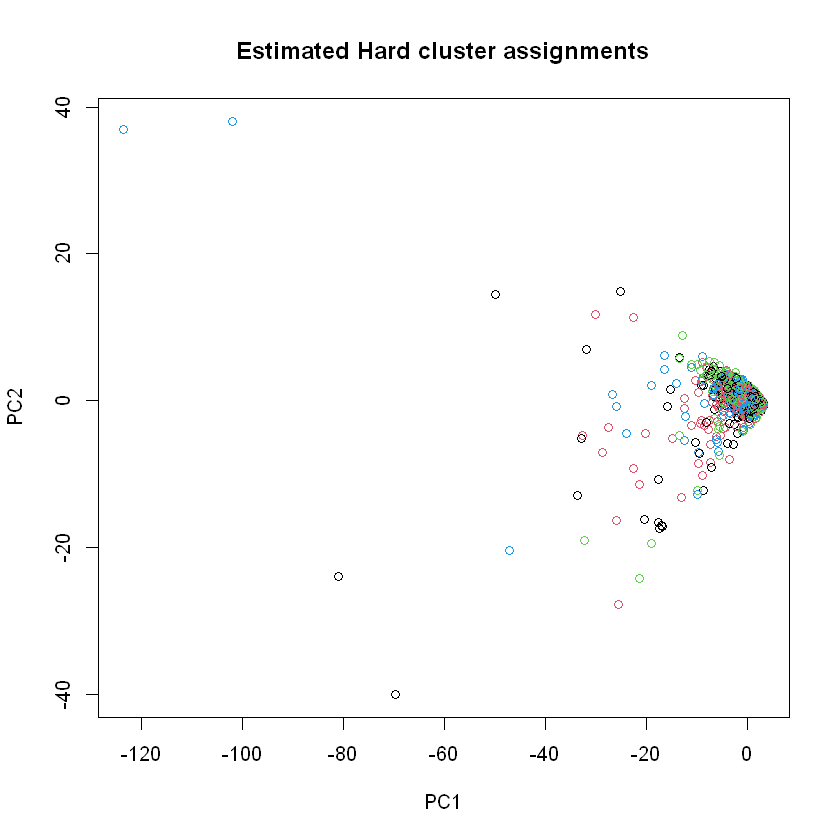

In [15]:
# plotting the hard cluster assignments for each document
label_hat = apply(hard_cluster_results$gamma, 1, which.max)
cluster_viz_func(t(counts), label_hat, 'Estimated Hard cluster assignments')

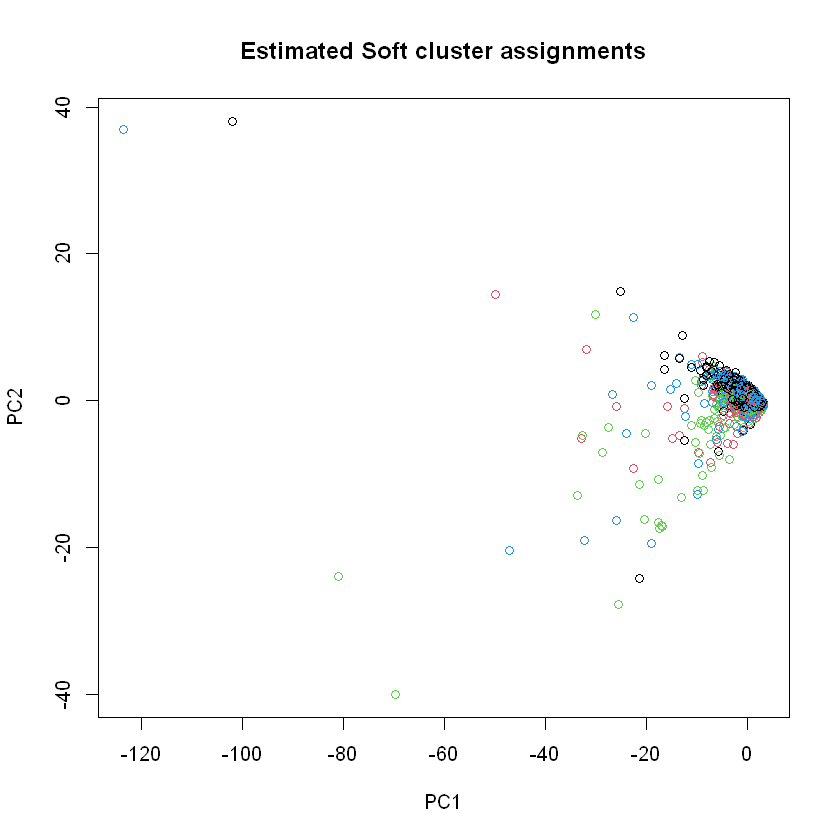

In [16]:
# plot soft cluster assignments for each document
label_hat = apply(soft_cluster_results$gamma, 1, which.max)
cluster_viz_func(t(counts), label_hat, 'Estimated Soft cluster assignments')